In [2]:
import symd
import matplotlib.pyplot as plt
import numpy as np

In [159]:
def run_sim(n, cell, group, w=None):
    md = symd.Symd(nparticles=n, cell=cell, ndims=2, images=2, force='lj', wyckoffs=w,
          group=group, steps=30000, exeDir='soft', start_temperature=0.5)
    md.remove_overlap()
    md.shrink()
    md.log_positions(frames=500)
    md.run()    
    return md

In [161]:
md = run_sim(5, [10, 10], 1)

Shrunk from 100.095 to 99.8962
New cell: [9.90149, 0.0, 0.0, 9.85903]


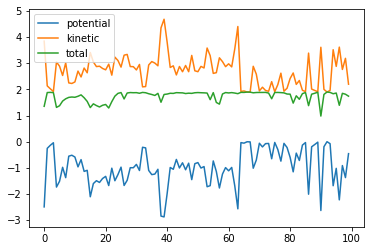

In [162]:
plt.plot(md.pe, label='potential')
plt.plot(md.ke, label='kinetic')
plt.plot(md.te, label='total')
plt.legend(loc='best')

In [ ]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot(traj, title='@_172135352171_', color='#333333', fps=60):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)
    points = ax.plot(traj[0,:,0], traj[0,:,1], color=color, marker='o', markeredgewidth=0.0, linestyle='None', alpha=1.0)[0]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.axis('off')
    xlim = np.quantile(traj[:,:,0], [0.1, 0.90])
    ylim = np.quantile(traj[:,:,1], [0.1, 0.90])
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points.set_data(traj[i,:,0], traj[i,:,1])    
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(1.0) for c in clips[1:]], padding=-1, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])

In [ ]:
c = []
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
for i,t in enumerate(titles):
    md = run_sim(4, [20, 20], i+1)
    color = colors[i % len(colors)]
    c.append(plot(md.positions, t, color))
    wycks = len(symd.groups.load_group(i+1, 2)['specpos'])
    for j in range(wycks):
        try:
            md = run_sim(4+j+1, [20, 20], i+1, w=[1] * (j+1))
            c.append(plot(md.positions, f'{t}-w{j}', color))
        except RuntimeError as e:
            print(e)
write_video(c, 'traj.mp4')
for ci in c:
    ci.close()

In [ ]:
cd = 500 / 60
md = int(135 / cd) * cd
print('Will cut to clips of length', md)
main_clip = editor.VideoFileClip("traj.mp4")
N = int(main_clip.duration / md) + 1
print('Will write', N, 'clips')
time = 0
i = 0
for i in range(N):
    clip = main_clip.subclip(i * md, min((i + 1) * md, main_clip.duration))
    clip.write_videofile(f'traj-{i}.mp4', fps=60)#, preset='slower', ffmpeg_params=['-tune', 'animation'])
    clip.close()
